# init

## imports

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import warnings

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import types as T
from pyspark.sql import Window as W

warnings.filterwarnings('ignore')

## configs

In [2]:
SPARK_THREADS = 16
SPARK_MEMORY = 16
SPARK_TIMEZONE = 'America/Vancouver'

In [2]:
BASE_PATH = os.path.expanduser('~/class/ad_click/data/raw_data/')
USER_DATA_PATH = BASE_PATH + 'user_profile.csv'
AD_CLICK_DATA_PATH = BASE_PATH + 'raw_sample.csv'
AD_INFO_DATA_PATH = BASE_PATH + 'ad_feature.csv'

## spark instantiation

In [4]:
spark = (
    SparkSession 
    .builder 
    .master('local[{}]'.format(SPARK_THREADS)) 
    .config('spark.driver.memory', '{}g'.format(SPARK_MEMORY)) 
    .config('spark.sql.session.timeZone', SPARK_TIMEZONE) 
    .getOrCreate()
)

24/03/23 07:08:17 WARN Utils: Your hostname, shaghayegh-ubuntu resolves to a loopback address: 127.0.1.1; using 10.0.0.66 instead (on interface wlp92s0)
24/03/23 07:08:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/23 07:08:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## util

In [5]:
def summerize_df(df):
    print(df.count())
    df.show(3)

# load data

In [6]:
user_df = spark.read.csv(USER_DATA_PATH, header = True, inferSchema=True)
summerize_df(user_df)

1061768
+------+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+
|userid|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |
+------+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+
|   234|        0|           5|                2|        5|        NULL|             3|         0|                    3|
|   523|        5|           2|                2|        2|           1|             3|         1|                    2|
|   612|        0|           8|                1|        2|           2|             3|         0|                 NULL|
+------+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+
only showing top 3 rows



In [7]:
ad_info_df = spark.read.csv(AD_INFO_DATA_PATH, header = True, inferSchema=True)
summerize_df(ad_info_df)

846811
+----------+-------+-----------+--------+-----+-----+
|adgroup_id|cate_id|campaign_id|customer|brand|price|
+----------+-------+-----------+--------+-----+-----+
|     63133|   6406|      83237|       1|95471|170.0|
|    313401|   6406|      83237|       1|87331|199.0|
|    248909|    392|      83237|       1|32233| 38.0|
+----------+-------+-----------+--------+-----+-----+
only showing top 3 rows



In [8]:
ad_click_df = spark.read.csv(AD_CLICK_DATA_PATH, header = True, inferSchema=True)
summerize_df(ad_click_df)

26557961
+------+----------+----------+-----------+------+---+
|  user|time_stamp|adgroup_id|        pid|nonclk|clk|
+------+----------+----------+-----------+------+---+
|581738|1494137644|         1|430548_1007|     1|  0|
|449818|1494638778|         3|430548_1007|     1|  0|
|914836|1494650879|         4|430548_1007|     1|  0|
+------+----------+----------+-----------+------+---+
only showing top 3 rows



# join

In [9]:
ad_click_df = ad_click_df.withColumnRenamed('user', 'userid')

ad_click_user_df = ad_click_df.join(user_df, on='userid')
merged_df = ad_click_user_df.join(ad_info_df, on='adgroup_id')

merged_df.persist()
summerize_df(merged_df)

25029435
+----------+-------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+-----+
|adgroup_id| userid|time_stamp|        pid|nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer| brand|price|
+----------+-------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+-----+
|       148|1040395|1494306282|430539_1007|     0|  1|       56|           8|                1|        2|           1|             3|         0|                    2|  11005|     395681|   50113|390701| 26.0|
|       148|1040395|1494374101|430539_1007|     1|  0|       56|           8|                1|        2|           1|             3|         0|           

# questions

## ad click distribution

In [10]:
(
    ad_click_df
    .groupby('clk')
    .count()
    .show()
)

+---+--------+
|clk|   count|
+---+--------+
|  1| 1366056|
|  0|25191905|
+---+--------+



## time interval

In [11]:
(
    ad_click_df
    .withColumn('time', F.from_unixtime(F.col('time_stamp')))
    .groupby()
    .agg(
        F.min('time'),
        F.max('time')) 
    .show()
)

+-------------------+-------------------+
|          min(time)|          max(time)|
+-------------------+-------------------+
|2017-05-05 09:00:00|2017-05-13 08:59:46|
+-------------------+-------------------+



## ad group count

In [12]:
(
    ad_info_df
    .groupby()
    .agg(
        F.count_distinct('adgroup_id'))
    .show()
)

+--------------------------+
|count(DISTINCT adgroup_id)|
+--------------------------+
|                    846811|
+--------------------------+



## campaign id count

In [13]:
(
    ad_info_df
    .groupby()
    .agg(
        F.count_distinct('campaign_id'))
    .show()
)

+---------------------------+
|count(DISTINCT campaign_id)|
+---------------------------+
|                     423436|
+---------------------------+



## ad category id count

In [14]:
(
    ad_info_df
    .groupby()
    .agg(
        F.count_distinct('cate_id'))
    .show()
)

+-----------------------+
|count(DISTINCT cate_id)|
+-----------------------+
|                   6769|
+-----------------------+



## ad brand count

In [15]:
(
    ad_info_df
    .groupby()
    .agg(
        F.count_distinct('brand'))
    .show()
)

+---------------------+
|count(DISTINCT brand)|
+---------------------+
|                99815|
+---------------------+



## ad max price

In [16]:
(
    ad_info_df
    .groupby()
    .agg(
        F.max('price'))
    .toPandas()
)

,max(price)
0,99999999.0


## ad user clicks

In [17]:
(
    ad_click_df
    .groupby('userid')
    .agg(
        F.sum('clk').alias('user_clicks'))
    .sort(F.desc('user_clicks'))
    .show()
)

+-------+-----------+
| userid|user_clicks|
+-------+-----------+
| 928284|        170|
| 569318|        165|
|1060021|        152|
|1054172|        147|
|1058909|        140|
| 490430|        131|
| 853650|        127|
|1005110|        126|
| 529160|        121|
| 220960|        120|
|1096948|        120|
|  40010|        117|
| 413706|        115|
| 401318|        114|
| 525363|        113|
| 143166|        112|
| 432055|        111|
| 341347|        110|
| 728105|        110|
| 373309|        109|
+-------+-----------+
only showing top 20 rows



In [18]:
(
    ad_click_df
    .groupby('userid')
    .agg(
        F.sum('clk').alias('user_clicks'))
    .groupby()
    .agg(
        F.max('user_clicks'))
    .show()
)

+----------------+
|max(user_clicks)|
+----------------+
|             170|
+----------------+



## ad user avg clicks

In [19]:
(
    ad_click_df
    .groupby('userid')
    .agg(
        F.sum('clk').alias('user_avg_clicks'))
    .groupby()
    .agg(
        F.avg('user_avg_clicks'))
    .show()
)

+--------------------+
|avg(user_avg_clicks)|
+--------------------+
|  1.1964800753944238|
+--------------------+



## user age level

In [20]:
(
    user_df
    .select('age_level')
    .distinct()
    .show()
)

+---------+
|age_level|
+---------+
|        1|
|        6|
|        3|
|        5|
|        4|
|        2|
|        0|
+---------+



## ad clks per day

In [21]:
(
    ad_click_df
    .withColumn('time', F.from_unixtime(F.col('time_stamp')))
    .withColumn('date', F.to_date(F.col('time')))
    .groupby('date')
    .agg(F.sum('clk').alias('user_clicks'))
    .orderBy('date')
    .show()
)

+----------+-----------+
|      date|user_clicks|
+----------+-----------+
|2017-05-05|      83260|
|2017-05-06|     173271|
|2017-05-07|     173406|
|2017-05-08|     173860|
|2017-05-09|     170410|
|2017-05-10|     175822|
|2017-05-11|     167258|
|2017-05-12|     164064|
|2017-05-13|      84705|
+----------+-----------+



## time gap between ads per userid

In [22]:
merged_df =(
    merged_df
    .withColumn('time', F.to_timestamp(F.col('time_stamp')))
)

def window_functions(df):
    window = W.partitionBy('userid').orderBy('time')
    
    window_df = (
        df
        .withColumn('last_row', F.lag('time').over(window))
    )
    
    return window_df
    
window_df = window_functions(merged_df)

window_df = (
    window_df
    .withColumn(
        'ad_gap_sec',
        (F.round
        (F.col('time').cast("long") - 
        F.col('last_row').cast("long")))
        .cast('int')
    )
)
window_df.drop('last_row').show(truncate=False)

+----------+------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------+-------------------+----------+
|adgroup_id|userid|time_stamp|pid        |nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer|brand |price |time               |ad_gap_sec|
+----------+------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------+-------------------+----------+
|691878    |31    |1494033821|430548_1007|1     |0  |6        |2           |2                |2        |1           |1             |0         |NULL                 |6426   |288940     |34125   |395343|398.0 |2017-05-05 18:23:41|NULL      |
|619242    |31    |1494033821|430548_100

# potential features

## most clked brand

In [23]:
(
    merged_df
    .groupby('brand')
    .agg(F.sum('clk').alias('user_clicks'))
    .sort(F.desc('user_clicks'))
    .show()
)

+------+-----------+
| brand|user_clicks|
+------+-----------+
|  NULL|     429375|
| 82527|      15007|
|146115|      13126|
|234846|      12989|
|247789|       9270|
|353787|       5227|
|337365|       4722|
|454237|       4233|
|143597|       3823|
|342760|       3213|
| 95766|       2851|
|255820|       2798|
|293023|       2528|
|188059|       2320|
|425589|       2151|
|235358|       2088|
|220468|       2082|
|181325|       1890|
|144123|       1886|
| 98931|       1867|
+------+-----------+
only showing top 20 rows



## age group ad clks

In [24]:
(
    merged_df
    .groupby('age_level')
    .agg(F.sum('clk').alias('user_clicks'))
    .sort(F.desc('user_clicks'))
    .show()
)

+---------+-----------+
|age_level|user_clicks|
+---------+-----------+
|        3|     386683|
|        4|     317358|
|        5|     242691|
|        2|     236328|
|        1|      76211|
|        6|      24760|
|        0|        482|
+---------+-----------+



## age group total of ad shown 

In [25]:
(
    merged_df
    .groupby('age_level')
    .agg(F.count('clk').alias('user_clicks'))
    .sort(F.desc('user_clicks'))
    .show()
)

+---------+-----------+
|age_level|user_clicks|
+---------+-----------+
|        3|    7573614|
|        4|    6406045|
|        5|    4652618|
|        2|    4567837|
|        1|    1379703|
|        6|     440429|
|        0|       9189|
+---------+-----------+



## age group ad clks avg percentage  

In [26]:
(
    merged_df
    .groupby('age_level')
    .agg((F.round(F.mean('clk')*100, 2)).alias('mean_user_clicks'))
    .sort(F.desc('mean_user_clicks'))
    .show()
)

+---------+----------------+
|age_level|mean_user_clicks|
+---------+----------------+
|        6|            5.62|
|        1|            5.52|
|        0|            5.25|
|        5|            5.22|
|        2|            5.17|
|        3|            5.11|
|        4|            4.95|
+---------+----------------+



## age_level 1 avg price 

In [27]:
(
    merged_df
    .filter(F.col('age_level') == 1)
    .agg((F.mean('price')))
    .show()
)

+-----------------+
|       avg(price)|
+-----------------+
|452.9304258017841|
+-----------------+



## age_level avg price

In [28]:
price_age_df = (
    merged_df
    .groupby('age_level')
    .agg((F.mean('price')))
    .orderBy('avg(price)')
    .show()
)

+---------+------------------+
|age_level|        avg(price)|
+---------+------------------+
|        1| 452.9304258017841|
|        2| 456.7676189671449|
|        0| 577.4065175753616|
|        3| 648.3438410843272|
|        4| 796.1136883677926|
|        5|1146.5841540160816|
|        6|1595.1099037983417|
+---------+------------------+



In [29]:
price_age_df = (
    merged_df
    .filter(F.col('clk') == 1)
    .groupby('age_level')
    .agg((F.mean('price')))
    .orderBy('avg(price)')
    .show()
)

+---------+------------------+
|age_level|        avg(price)|
+---------+------------------+
|        1| 350.6007624883544|
|        0| 630.0704771784233|
|        2|  785.717774618327|
|        3| 819.5196298777036|
|        4| 922.8729005413444|
|        6|1171.0726837641357|
|        5|1610.9624209385613|
+---------+------------------+



## avg price/ age level plot

In [30]:
price_age_pandas_df = (
    merged_df
    .groupby('age_level')
    .agg((F.mean('price')))
    .toPandas()
)

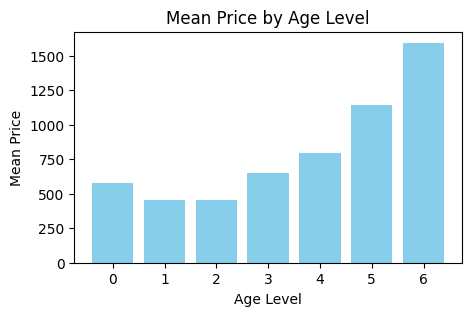

In [31]:
price_age_pandas_df.sort_values('age_level', inplace=True)

plt.figure(figsize=(5, 3))
plt.bar(price_age_pandas_df['age_level'], price_age_pandas_df['avg(price)'], color='skyblue')
plt.xlabel('Age Level')
plt.ylabel('Mean Price')
plt.title('Mean Price by Age Level')
plt.show()

## new user class level

In [32]:
(
    merged_df
    .groupby('new_user_class_level ')
    .count()
    .show()
)

+---------------------+-------+
|new_user_class_level |  count|
+---------------------+-------+
|                 NULL|6696303|
|                    1|1881278|
|                    3|4620080|
|                    4|3706349|
|                    2|8125425|
+---------------------+-------+



## females ad clk mean price  

In [33]:
(
    merged_df
    .filter(F.col('final_gender_code') == 2)
    .filter(F.col('clk') == 1)
    .agg((F.mean('price')))
    .show()
)

+----------------+
|      avg(price)|
+----------------+
|555.540261045253|
+----------------+



## females & male ad clk mean price  

In [34]:
(
    merged_df
    .filter(F.col('clk') == 1)
    .groupby('final_gender_code')
    .agg((F.mean('price')))
    .show()
)

+-----------------+------------------+
|final_gender_code|        avg(price)|
+-----------------+------------------+
|                1|2144.9927776775953|
|                2|  555.540261045253|
+-----------------+------------------+



## ave time gap of ads

In [35]:
window_filtered_df = (
    window_df
    .filter((F.col("ad_gap_sec") != 0) & (F.col("ad_gap_sec").isNotNull()))
    .groupby()
    .agg(F.avg(F.col('ad_gap_sec')))
)
window_filtered_df.show()

+------------------+
|   avg(ad_gap_sec)|
+------------------+
|50370.631997075034|
+------------------+



## clk rate per user

In [36]:
accept_rate_df = (
    merged_df
    .groupby('userid')
    .agg(F.avg('clk').alias('accept_rate'))
)
accept_rate_df = (
    accept_rate_df
    .withColumn('clk_rate', F.round('accept_rate', 3))
)
accept_rate_df = accept_rate_df.drop('accept_rate')

window_df = window_df.join(other = accept_rate_df, on = 'userid', how = 'left')

summerize_df(window_df)

25029435


+------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+-----+-------------------+-------------------+----------+--------+
|userid|adgroup_id|time_stamp|        pid|nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer| brand|price|               time|           last_row|ad_gap_sec|clk_rate|
+------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+-----+-------------------+-------------------+----------+--------+
|    31|    691878|1494033821|430548_1007|     1|  0|        6|           2|                2|        2|           1|             1|         0|                 NULL|   6426|     288940|   34125|39

## confusion matrix on clk rate

In [37]:
(
    window_df
    .withColumn(
        "random_clk", 
        (F.rand() < 0.04).cast("int"))
    .groupby('clk', 'random_clk')
    .count()
    .sort('clk', 'random_clk')
).show()

+---+----------+--------+
|clk|random_clk|   count|
+---+----------+--------+
|  0|         0|22795789|
|  0|         1|  949133|
|  1|         0| 1233103|
|  1|         1|   51410|
+---+----------+--------+



## prediction metrics

In [38]:
print('accuracy', (22795289 + 51501) / (22795289 + 949633 + 1233012 + 51501))

accuracy 0.9127968729617748


In [39]:
print('percision', (51501) / (949633 + 51501))

percision 0.05144266401900245


In [40]:
print('recall', (51501) / (1233012 + 51501))

recall 0.04009379430180932


## clk rate in a day divided in three 

In [41]:
morning_start = 0
midday_start = 8
night_start = 16

window_df = (
    window_df
    .withColumn("hour", F.hour("time"))
)

window_df = (
    window_df
    .withColumn("timestamp",
    F.when((F.col("hour") >= morning_start) & (F.col("hour") < midday_start), "morning")
    .when((F.col("hour") >= morning_start) & (F.col("hour") < midday_start), "morning")
    .otherwise("night"))
)

window_df.show()

+------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------+-------------------+-------------------+----------+--------+----+---------+
|userid|adgroup_id|time_stamp|        pid|nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer| brand| price|               time|           last_row|ad_gap_sec|clk_rate|hour|timestamp|
+------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------+-------------------+-------------------+----------+--------+----+---------+
|    31|    691878|1494033821|430548_1007|     1|  0|        6|           2|                2|        2|           1|             1|         0|     

In [42]:
timestamp_clk_df = (
    window_df
    .groupby('timestamp')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'))
)
summerize_df(timestamp_clk_df)

2
+---------+-----------+
|timestamp|average_clk|
+---------+-----------+
|    night|      0.051|
|  morning|     0.0517|
+---------+-----------+



## hourly clk rate 

In [43]:
hour_clk_df = (
    window_df
    .groupby('hour')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'), F.count('clk'))
)
hour_clk_df.sort('average_clk').show()

+----+-----------+----------+
|hour|average_clk|count(clk)|
+----+-----------+----------+
|  16|     0.0476|    827870|
|  15|     0.0486|    599629|
|  14|     0.0492|    254014|
|  11|     0.0502|    200816|
|  12|     0.0505|    134040|
|  20|     0.0506|   1319123|
|  17|     0.0507|    989967|
|   2|     0.0507|   1237498|
|  10|     0.0511|    370928|
|  21|     0.0511|   1413474|
|   3|     0.0512|   1135449|
|  13|     0.0514|    126106|
|   7|     0.0514|   1819242|
|   1|     0.0515|   1333687|
|   8|     0.0515|   1326694|
|  22|     0.0516|   1447098|
|   9|     0.0516|    753054|
|  19|     0.0517|   1358179|
|   4|     0.0519|   1226722|
|   0|     0.0519|   1364552|
+----+-----------+----------+
only showing top 20 rows



## time clk count

In [44]:
timestamp_clk_count_df = (
    window_df
    .groupby('timestamp')
    .agg(F.count('clk').alias('count_clk'))
)
summerize_df(timestamp_clk_count_df)

2
+---------+---------+
|timestamp|count_clk|
+---------+---------+
|    night| 13673732|
|  morning| 11355703|
+---------+---------+



## ad category clk rate 

In [45]:
cate_clk_df = (
    merged_df
    .groupBy('cate_id')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'), F.count('clk'))
    .orderBy(F.desc('count(clk)'))
)
cate_clk_df.show()

+-------+-----------+----------+
|cate_id|average_clk|count(clk)|
+-------+-----------+----------+
|   6261|     0.0616|   2755836|
|   1665|     0.0562|   1457812|
|   4520|     0.0471|   1039271|
|   4281|     0.0566|    915516|
|   4282|     0.0537|    909395|
|   6426|     0.0494|    738942|
|   4284|     0.0566|    529330|
|   4280|     0.0551|    506910|
|   4283|     0.0525|    451866|
|   6423|     0.0487|    430280|
|   4505|     0.0347|    421205|
|   4292|     0.0547|    359581|
|   6183|     0.0411|    339967|
|   4385|     0.0359|    310340|
|   6421|     0.0489|    274329|
|   4521|     0.0573|    268598|
|    856|     0.0509|    268503|
|    562|     0.0575|    249305|
|   6300|     0.0557|    245083|
|   4288|     0.0481|    209322|
+-------+-----------+----------+
only showing top 20 rows



## brand clk rate

In [46]:
brand_clk_df = (
    merged_df
    .groupBy('brand')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'), F.count('clk'))
    .sort(F.desc('count(clk)'))
)
brand_clk_df.show()

+------+-----------+----------+
| brand|average_clk|count(clk)|
+------+-----------+----------+
|  NULL|      0.055|   7802592|
|234846|     0.0599|    216874|
| 82527|     0.0711|    210968|
|146115|      0.069|    190308|
|247789|     0.0501|    184926|
|353787|     0.0447|    117013|
|454237|     0.0551|     76781|
| 98931|     0.0259|     72215|
|143597|      0.053|     72114|
|342760|     0.0473|     67877|
| 95766|     0.0517|     55132|
|337365|     0.0867|     54472|
|293023|      0.049|     51565|
|188059|     0.0462|     50180|
|255820|     0.0613|     45626|
|220468|     0.0468|     44534|
|260362|     0.0412|     42139|
|425589|     0.0539|     39927|
|235358|     0.0562|     37132|
|269352|     0.0459|     37017|
+------+-----------+----------+
only showing top 20 rows



## gender clk rate

In [47]:
gender_clk_df = (
    merged_df
    .groupBy('final_gender_code')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'))
)
summerize_df(gender_clk_df)

2
+-----------------+-----------+
|final_gender_code|average_clk|
+-----------------+-----------+
|                1|     0.0484|
|                2|     0.0524|
+-----------------+-----------+



## occupation clk rate

In [48]:
occupation_clk_df = (
    merged_df
    .groupBy('occupation')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'))
)
summerize_df(occupation_clk_df)

2
+----------+-----------+
|occupation|average_clk|
+----------+-----------+
|         1|     0.0515|
|         0|     0.0513|
+----------+-----------+



## consumption level clk rate

In [49]:
consumption_clk_df = (
    merged_df
    .groupBy('pvalue_level')
    .agg(F.round(F.avg('clk'), 5).alias('average_clk'), F.count('clk'))
    .sort(F.desc('count(clk)'))
)
summerize_df(consumption_clk_df)

4
+------------+-----------+----------+
|pvalue_level|average_clk|count(clk)|
+------------+-----------+----------+
|        NULL|    0.05154|  13024272|
|           2|    0.05137|   6991303|
|           1|    0.05146|   4117894|
+------------+-----------+----------+
only showing top 3 rows



## shopping level clk rate

In [50]:
shopping_level_clk_df = (
    merged_df
    .groupBy('shopping_level')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'), F.count('clk'))
    .sort(F.desc('count(clk)'))
)
summerize_df(shopping_level_clk_df)

3
+--------------+-----------+----------+
|shopping_level|average_clk|count(clk)|
+--------------+-----------+----------+
|             3|     0.0511|  21316498|
|             2|     0.0517|   2594215|
|             1|      0.054|   1118722|
+--------------+-----------+----------+



## age level 3: ad category clk rate 

In [51]:
age3_cate_clk_df = (
    merged_df
    .filter(F.col('age_level') == 3)
    .groupBy('cate_id')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'), F.count('clk'))
    .sort(F.desc('count(clk)'))
)
age3_cate_clk_df.show()

+-------+-----------+----------+
|cate_id|average_clk|count(clk)|
+-------+-----------+----------+
|   6261|     0.0613|    842284|
|   1665|     0.0552|    468098|
|   4520|     0.0459|    297745|
|   4281|     0.0574|    286024|
|   4282|     0.0542|    285169|
|   6426|     0.0501|    244802|
|   4284|     0.0563|    165075|
|   6423|     0.0484|    134266|
|   4283|     0.0525|    133089|
|   4280|     0.0555|    131981|
|   6183|     0.0428|    127492|
|   4292|     0.0562|    111421|
|   4505|     0.0319|    101543|
|    856|     0.0512|     94830|
|   6421|      0.049|     87266|
|   6519|     0.0526|     84318|
|   4385|     0.0372|     83068|
|   4521|     0.0573|     79144|
|   6736|     0.0555|     68585|
|   6427|     0.0469|     66284|
+-------+-----------+----------+
only showing top 20 rows



## age level 3: ad hour clk rate 

In [52]:
age3_hour_clk_df = (
    window_df
    .filter(F.col('age_level') == 3)
    .groupBy('hour')
    .agg(F.round(F.avg('clk'), 4).alias('average_clk'))
    .orderBy(F.desc('average_clk'))
)
age3_hour_clk_df.show()

+----+-----------+
|hour|average_clk|
+----+-----------+
|  23|     0.0527|
|   5|     0.0523|
|   6|     0.0521|
|  13|     0.0519|
|   9|     0.0518|
|   4|     0.0518|
|   0|     0.0516|
|  18|     0.0516|
|   8|     0.0515|
|  22|     0.0514|
|  19|     0.0513|
|  21|      0.051|
|   7|     0.0508|
|   1|     0.0507|
|  10|     0.0507|
|  17|     0.0504|
|   3|     0.0503|
|  20|     0.0503|
|  11|     0.0503|
|   2|     0.0502|
+----+-----------+
only showing top 20 rows



## age level 3: ad shown time & clk rate 

In [53]:
age3_time_clk_count_df = (
    window_df
    .filter(F.col('age_level') == 3)
    .groupby('timestamp')
    .agg(F.count('clk').alias('count_clk'))
)
age3_time_clk_count_df.show()

+---------+---------+
|timestamp|count_clk|
+---------+---------+
|    night|  4137219|
|  morning|  3436395|
+---------+---------+



## age level 3: sum of ad shown time & clk rate 

In [54]:
age3_time_clk_sum_df = (
    window_df
    .filter(F.col('age_level') == 3)
    .groupby('timestamp')
    .agg(F.sum('clk').alias('count_clk'))
)
age3_time_clk_sum_df.show()

+---------+---------+
|timestamp|count_clk|
+---------+---------+
|    night|   210482|
|  morning|   176201|
+---------+---------+



## adgroup count

In [55]:
window_df.groupby('adgroup_id').count().sort(F.desc('count')).show()

+----------+-----+
|adgroup_id|count|
+----------+-----+
|    710164|68059|
|    725105|24972|
|    736349|24366|
|    747157|23740|
|    836889|22560|
|    659289|21800|
|    632644|20507|
|    659211|16623|
|    632432|16030|
|    711852|15098|
|    690381|14936|
|    819177|14817|
|    759279|14739|
|    656398|14535|
|    684724|14395|
|    715171|14174|
|    627130|14082|
|    512438|13093|
|    608584|13086|
|    671481|12801|
+----------+-----+
only showing top 20 rows



## campaign id count

In [56]:
window_df.groupby('campaign_id').count().sort(F.desc('count')).show()

+-----------+------+
|campaign_id| count|
+-----------+------+
|     359520|124128|
|     405490|105391|
|     118601| 73770|
|     360936| 60103|
|      98970| 45797|
|     105960| 40639|
|     404347| 37691|
|      82320| 37010|
|     414149| 34415|
|     282035| 33747|
|     396664| 31974|
|     353477| 30461|
|     136030| 29024|
|     352747| 27860|
|     397994| 27629|
|     162326| 27542|
|     129474| 27316|
|     225336| 26464|
|     408804| 25519|
|     125699| 23593|
+-----------+------+
only showing top 20 rows



# model features

## ad counts and sum per userid

In [68]:
def get_user_features(df):
    window = W.partitionBy('userid').orderBy('time', F.rand())
    
    window_df = (
        df
        .withColumn('user_ad_count', F.count('clk').over(window))
        .withColumn('user_ad_clk_count', F.sum('clk').over(window))
    )
    
    return window_df
    
users_features_df = get_user_features(window_df)
users_features_df.select('userid', 'time', 'user_ad_count', 'user_ad_clk_count').sort('userid', 'time').show(50)

+------+-------------------+-------------+-----------------+
|userid|               time|user_ad_count|user_ad_clk_count|
+------+-------------------+-------------+-----------------+
|     1|2017-05-10 21:50:36|            1|                0|
|     1|2017-05-11 23:45:25|            3|                0|
|     1|2017-05-11 23:45:25|            2|                0|
|     1|2017-05-11 23:45:25|            4|                0|
|     2|2017-05-08 06:33:12|            3|                0|
|     2|2017-05-08 06:33:12|            2|                0|
|     2|2017-05-08 06:33:12|            1|                1|
|     3|2017-05-07 16:07:35|            1|                1|
|     3|2017-05-07 16:07:35|            2|                1|
|     3|2017-05-07 16:41:33|            5|                1|
|     3|2017-05-07 16:41:33|            3|                1|
|     3|2017-05-07 16:41:33|            4|                1|
|     3|2017-05-10 17:44:04|            6|                1|
|     3|2017-05-10 17:44

## ad counts and sum per adgroup id

In [65]:
def ad_window_functions(df):
    window = W.partitionBy('adgroup_id').orderBy('time')
    
    window_df = (
        df
        .withColumn('adgroup_count', F.count('clk').over(window))
        .withColumn('adgroup_clk_count', F.sum('clk').over(window))
    )
    
    return window_df
    
window_df = ad_window_functions(users_features_df)
window_df.select('adgroup_id', 'time', 'adgroup_count', 'adgroup_clk_count').sort('adgroup_id', 'time').show(50)

+----------+-------------------+-------------+-----------------+
|adgroup_id|               time|adgroup_count|adgroup_clk_count|
+----------+-------------------+-------------+-----------------+
|         1|2017-05-06 23:14:04|            1|                0|
|         2|2017-05-08 17:38:53|            1|                0|
|         2|2017-05-09 05:38:06|            2|                0|
|         2|2017-05-10 00:33:38|            3|                0|
|         2|2017-05-12 18:08:46|            4|                0|
|         2|2017-05-12 18:43:57|            5|                0|
|         2|2017-05-12 21:21:21|            6|                0|
|         4|2017-05-12 21:47:59|            1|                0|
|         5|2017-05-12 21:50:29|            1|                0|
|         6|2017-05-12 23:27:30|            1|                0|
|         7|2017-05-06 20:57:22|            1|                0|
|         7|2017-05-09 03:06:09|            2|                0|
|         7|2017-05-10 07

## ad counts and sum per campaign id

In [59]:
def ad_window_functions(df):
    window = W.partitionBy('campaign_id').orderBy('time')
    
    window_df = (
        df
        .withColumn('campaign_count', F.count('clk').over(window))
        .withColumn('campaign_clk_count', F.sum('clk').over(window))
    )
    
    return window_df
    
window_df = ad_window_functions(window_df)
window_df.show()

+-------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+-----+-----+-------------------+-------------------+----------+--------+----+---------+--------+---------+-------------+-----------------+--------------+------------------+
| userid|adgroup_id|time_stamp|        pid|nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer|brand|price|               time|           last_row|ad_gap_sec|clk_rate|hour|timestamp|ad_count|clk_count|adgroup_count|adgroup_clk_count|campaign_count|campaign_clk_count|
+-------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+-----+-----+-------------------+-------------------+----------+------

## ad counts and sum per cate id

In [60]:
def ad_window_functions(df):
    window = W.partitionBy('cate_id').orderBy('time')
    
    window_df = (
        df
        .withColumn('cate_count', F.count('clk').over(window))
        .withColumn('cate_clk_count', F.sum('clk').over(window))
    )
    
    return window_df
    
window_df = ad_window_functions(window_df)
window_df.show()

+-------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------+-------------------+-------------------+----------+--------+----+---------+--------+---------+-------------+-----------------+--------------+------------------+----------+--------------+
| userid|adgroup_id|time_stamp|        pid|nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer| brand| price|               time|           last_row|ad_gap_sec|clk_rate|hour|timestamp|ad_count|clk_count|adgroup_count|adgroup_clk_count|campaign_count|campaign_clk_count|cate_count|cate_clk_count|
+-------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------

## male & female ad clk counts and sum per cate id

In [61]:
def ad_window_functions(df):
    window = W.partitionBy('cate_id').orderBy('time')
    
    window_df = (
        df
        .withColumn("female_cate_count", F.when((F.col("final_gender_code") == 1), F.count('clk').over(window)))
        .withColumn("female_cate_clk_count", F.when((F.col("final_gender_code") == 1), F.sum('clk').over(window)))
        .withColumn("male_cate_count", F.when((F.col("final_gender_code") == 2), F.count('clk').over(window)))
        .withColumn("male_cate_clk_count", F.when((F.col("final_gender_code") == 2), F.sum('clk').over(window)))
    )

    return window_df
    
window_df = ad_window_functions(window_df)
window_df.show()

+-------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------+-------------------+-------------------+----------+--------+----+---------+--------+---------+-------------+-----------------+--------------+------------------+----------+--------------+-----------------+---------------------+---------------+-------------------+
| userid|adgroup_id|time_stamp|        pid|nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer| brand| price|               time|           last_row|ad_gap_sec|clk_rate|hour|timestamp|ad_count|clk_count|adgroup_count|adgroup_clk_count|campaign_count|campaign_clk_count|cate_count|cate_clk_count|female_cate_count|female_cate_clk_count|male_cate_count|male_cate_clk_count|
+-------+----------+----------+-----------+------+---+--

In [61]:
def ad_window_functions(df):
    window = W.partitionBy('cate_id', 'final_gender_code').orderBy('time')
    
    window_df = (
        df
        .withColumn('cat_gender_ad_count', F.count('clk').over(window))
        .withColumn('cat_gender_ad_clk_count', F.sum('clk').over(window))
    )

    return window_df
    
window_df = ad_window_functions(window_df)
window_df.show()

+-------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------+-------------------+-------------------+----------+--------+----+---------+--------+---------+-------------+-----------------+--------------+------------------+----------+--------------+-----------------+---------------------+---------------+-------------------+
| userid|adgroup_id|time_stamp|        pid|nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer| brand| price|               time|           last_row|ad_gap_sec|clk_rate|hour|timestamp|ad_count|clk_count|adgroup_count|adgroup_clk_count|campaign_count|campaign_clk_count|cate_count|cate_clk_count|female_cate_count|female_cate_clk_count|male_cate_count|male_cate_clk_count|
+-------+----------+----------+-----------+------+---+--

In [61]:
def ad_window_functions(df):
    window = W.partitionBy('cate_id', 'final_gender_code').orderBy('time')
    
    window_df = (
        df
        .withColumn('cat_gender_ad_count', F.count('clk').over(window))
        .withColumn('cat_gender_ad_clk_count', F.sum('clk').over(window))
    )

    return window_df
    
window_df = ad_window_functions(window_df)
window_df.show()

+-------+----------+----------+-----------+------+---+---------+------------+-----------------+---------+------------+--------------+----------+---------------------+-------+-----------+--------+------+------+-------------------+-------------------+----------+--------+----+---------+--------+---------+-------------+-----------------+--------------+------------------+----------+--------------+-----------------+---------------------+---------------+-------------------+
| userid|adgroup_id|time_stamp|        pid|nonclk|clk|cms_segid|cms_group_id|final_gender_code|age_level|pvalue_level|shopping_level|occupation|new_user_class_level |cate_id|campaign_id|customer| brand| price|               time|           last_row|ad_gap_sec|clk_rate|hour|timestamp|ad_count|clk_count|adgroup_count|adgroup_clk_count|campaign_count|campaign_clk_count|cate_count|cate_clk_count|female_cate_count|female_cate_clk_count|male_cate_count|male_cate_clk_count|
+-------+----------+----------+-----------+------+---+--